#  PROGETTO FINALE IDS 

## Analisi e predizione dei risultati del campionato di Serie A 2023/2024

In questo progetto utilizzeremo un dataset della stagione di calcio della Serie A 2023/2024 per predire le ultime 5 giornate (dalla 33° alla 38°).

### Obiettivo del progetto
In un campionato con 20 squadre e un totale di 38 giornate, ogni squadra gioca 38 partite (una per giornata). Vogliamo considerare le ultime 5 giornate del campionato, quindi 50 partite in totale (10 partite per giornata × 5 giornate).

Per ciascuna partita, proveremo a prevedere il risultato usando uno dei seguenti segni:

- **1**: vittoria della squadra di casa
- **X**: pareggio
- **2**: vittoria della squadra in trasferta

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
import seaborn as sns

## 1. Preparazione e pulizia dei dati

Importiamo la tabella Serie A_matches_23_24.csv, che contiene i risultati di tutte le partite del campionato, e visualizziamo le prime righe per comprendere la struttura dei dati.

In [53]:
matches = pd.read_csv('dataset/Serie A_matches_23_24.csv')
matches.head()


,Round,Round Name,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,1,1,Empoli,Hellas Verona,2023-08-19T16:30:00Z,True,True,False,False,0_1,Full-Time,NaN,NaN,NaN,NaN
1,1,1,Frosinone,Napoli,2023-08-19T16:30:00Z,True,True,False,False,1_3,Full-Time,NaN,NaN,NaN,NaN
2,1,1,Genoa,Fiorentina,2023-08-19T18:45:00Z,True,True,False,False,1_4,Full-Time,NaN,NaN,NaN,NaN
3,1,1,Inter,Monza,2023-08-19T18:45:00Z,True,True,False,False,2_0,Full-Time,NaN,NaN,NaN,NaN
4,1,1,Roma,Salernitana,2023-08-20T16:30:00Z,True,True,False,False,2_2,Full-Time,NaN,NaN,NaN,NaN


### Pulizia dei dati

Analizziamo le colonne del dataset e rimuoviamo quelle non necessarie:
- Le colonne 'Unnamed: xx' non contengono dati informativi
- 'Round Name' e 'Round' contengono informazioni ridondanti
- "UTC Time", "Finished", "Started", "Cancelled", "Awarded", "Match Status" sono irrilevanti per il nostro modello di predizione

In [54]:
drop_columns = ['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14','Round Name', "UTC Time", "Finished", "Started", "Cancelled", "Awarded", "Match Status"]
matches.drop(drop_columns, axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,Score
0,1,Empoli,Hellas Verona,0_1
1,1,Frosinone,Napoli,1_3
2,1,Genoa,Fiorentina,1_4
3,1,Inter,Monza,2_0
4,1,Roma,Salernitana,2_2


In [55]:
# Verifichiamo la presenza di valori nulli
matches.isnull().sum()

Round        0
Home Team    0
Away Team    0
Score        0
dtype: int64

### Trasformazione dei dati

La colonna 'Score' presenta il punteggio in un'unica stringa. Procediamo a suddividerla in due colonne separate per una migliore analisi:
- **Score_casa**: gol segnati dalla squadra di casa
- **Score_trasferta**: gol segnati dalla squadra in trasferta

In [56]:
matches[['Score_casa', 'Score_trasferta']] = matches['Score'].str.split('_', expand=True).astype(int)
matches.drop('Score', axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,Score_casa,Score_trasferta
0,1,Empoli,Hellas Verona,0,1
1,1,Frosinone,Napoli,1,3
2,1,Genoa,Fiorentina,1,4
3,1,Inter,Monza,2,0
4,1,Roma,Salernitana,2,2


### Creazione della variabile target

Creiamo la colonna 'Risultato' che rappresenterà la nostra variabile target da predire:
- **1**: vittoria della squadra di casa (Score_casa > Score_trasferta)
- **X**: pareggio (Score_casa = Score_trasferta)
- **2**: vittoria della squadra in trasferta (Score_casa < Score_trasferta)

In [57]:
matches.loc[matches['Score_casa'] > matches['Score_trasferta'], 'Risultato'] = '1'
matches.loc[matches['Score_casa'] < matches['Score_trasferta'], 'Risultato'] = '2'
matches.loc[matches['Score_casa'] == matches['Score_trasferta'], 'Risultato'] = 'X'

matches.head()


,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato
0,1,Empoli,Hellas Verona,0,1,2
1,1,Frosinone,Napoli,1,3,2
2,1,Genoa,Fiorentina,1,4,2
3,1,Inter,Monza,2,0,1
4,1,Roma,Salernitana,2,2,X


Il nostro dataset è ora pronto per l'analisi, con tutte le informazioni necessarie organizzate in modo chiaro ed efficiente.

## Analisi offensiva e difensiva delle squadre

Esaminiamo il rendimento offensivo e difensivo delle squadre. Questo ci può aiutare a capire quali squadre segnano di più e quali subiscono meno gol, fattori determinanti per predire i risultati.

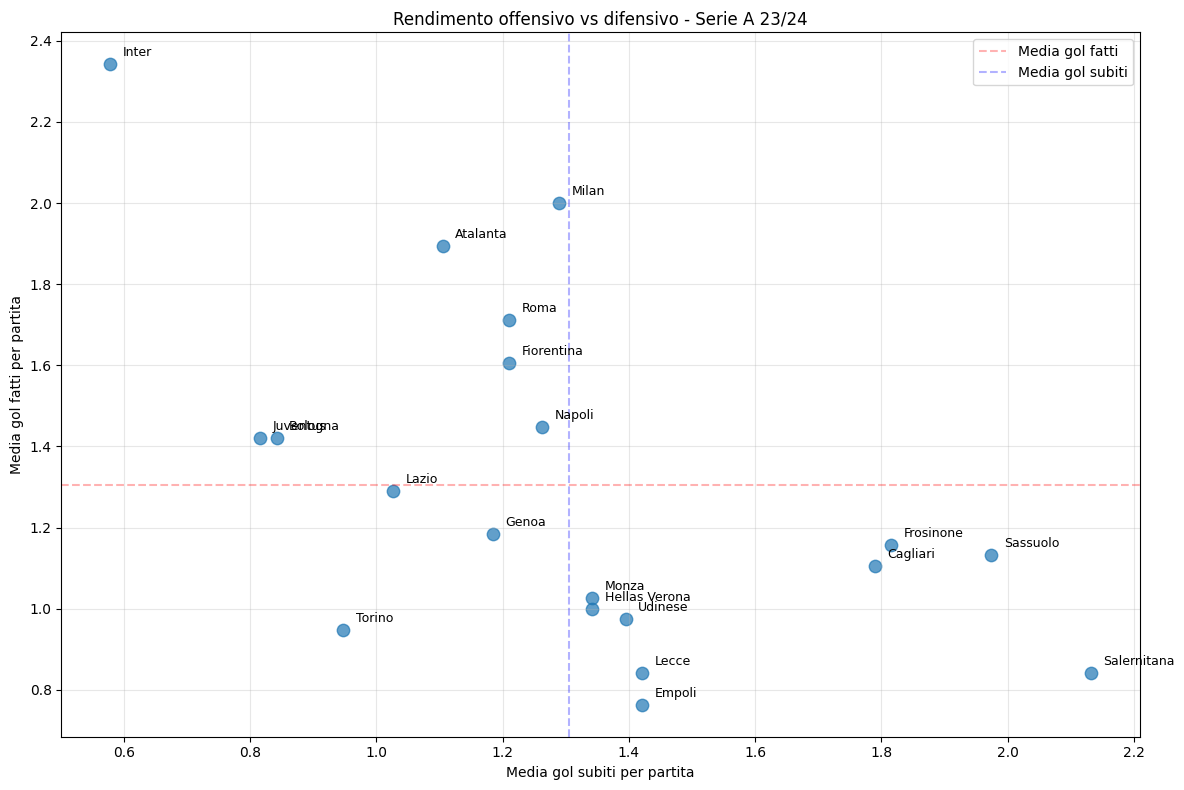

In [58]:
# Analisi offensiva e difensiva delle squadre direttamente dal DataFrame matches
# Dati per le squadre quando giocano in casa
home_stats = matches.groupby('Home Team').agg(
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
    partite_casa=('Round', 'count')
).reset_index()

# Dati per le squadre quando giocano in trasferta
away_stats = matches.groupby('Away Team').agg(
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
    partite_trasferta=('Round', 'count')
).reset_index()

# Unione dei due dataframe
team_stats = pd.merge(
    home_stats,
    away_stats,
    left_on='Home Team',
    right_on='Away Team',
    how='outer'
)

# Rinomina le colonne per chiarezza
team_stats = team_stats.rename(columns={'Home Team': 'name'})
team_stats.drop('Away Team', axis=1, inplace=True)

# Calcolo medie gol fatti e subiti
team_stats['Media_gol_fatti'] = (team_stats['gol_fatti_casa'] + team_stats['gol_fatti_trasferta']) / \
                               (team_stats['partite_casa'] + team_stats['partite_trasferta'])
team_stats['Media_gol_subiti'] = (team_stats['gol_subiti_casa'] + team_stats['gol_subiti_trasferta']) / \
                               (team_stats['partite_casa'] + team_stats['partite_trasferta'])

# Plottiamo un grafico a dispersione
plt.figure(figsize=(12, 8))
plt.scatter(team_stats['Media_gol_subiti'], team_stats['Media_gol_fatti'], s=80, alpha=0.7)

# Aggiungiamo i nomi delle squadre
for idx, row in team_stats.iterrows():
    plt.annotate(row['name'],
                 (row['Media_gol_subiti'] + 0.02, row['Media_gol_fatti'] + 0.02),
                 fontsize=9)

plt.axhline(y=team_stats['Media_gol_fatti'].mean(), color='r', linestyle='--', alpha=0.3, label='Media gol fatti')
plt.axvline(x=team_stats['Media_gol_subiti'].mean(), color='b', linestyle='--', alpha=0.3, label='Media gol subiti')

plt.xlabel('Media gol subiti per partita')
plt.ylabel('Media gol fatti per partita')
plt.title('Rendimento offensivo vs difensivo - Serie A 23/24')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Analisi del fattore campo

Il fattore campo è fondamentale nel calcio: il supporto del pubblico, la familiarità con il terreno e minori spostamenti possono contribuire significativamente ai risultati. Analizziamo quanto questo influenzi le squadre di Serie A.

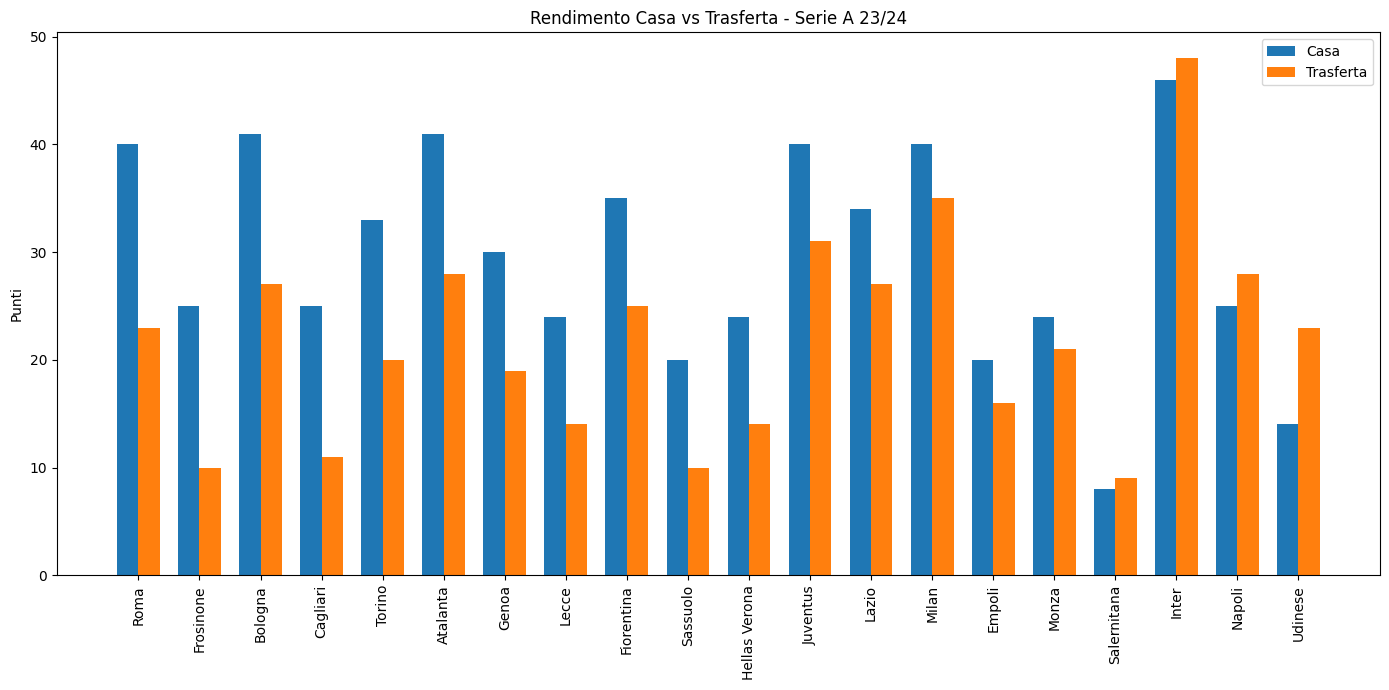

,name,points_home,points_away,points_diff
15,Roma,40,23,17
5,Frosinone,25,10,15
1,Bologna,41,27,14
2,Cagliari,25,11,14
18,Torino,33,20,13
0,Atalanta,41,28,13
6,Genoa,30,19,11
11,Lecce,24,14,10
4,Fiorentina,35,25,10
17,Sassuolo,20,10,10


In [59]:
# Analisi del rendimento casa vs trasferta usando solo il dataframe matches

# Aggreghiamo i dati per squadra di casa
home_performance = matches.groupby('Home Team').agg(
    partite_casa=('Round', 'count'),
    vittorie_casa=('Risultato', lambda x: (x == '1').sum()),
    pareggi_casa=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_casa=('Risultato', lambda x: (x == '2').sum()),
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
).reset_index()

# Aggreghiamo i dati per squadra in trasferta
away_performance = matches.groupby('Away Team').agg(
    partite_trasferta=('Round', 'count'),
    vittorie_trasferta=('Risultato', lambda x: (x == '2').sum()),
    pareggi_trasferta=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_trasferta=('Risultato', lambda x: (x == '1').sum()),
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
).reset_index()

# Uniamo i due dataframes
home_vs_away = pd.merge(
    home_performance,
    away_performance,
    left_on='Home Team',
    right_on='Away Team',
    suffixes=('', '_away')
)
home_vs_away = home_vs_away.rename(columns={'Home Team': 'name'})
home_vs_away.drop('Away Team', axis=1, inplace=True)

# Calcolo punti casa/trasferta (3 punti vittoria, 1 punto pareggio)
home_vs_away['points_home'] = home_vs_away['vittorie_casa'] * 3 + home_vs_away['pareggi_casa']
home_vs_away['points_away'] = home_vs_away['vittorie_trasferta'] * 3 + home_vs_away['pareggi_trasferta']

# Calcolo differenza punti
home_vs_away['points_diff'] = home_vs_away['points_home'] - home_vs_away['points_away']

# Ordinamento per chi ha più differenza casa/trasferta
home_vs_away_sorted = home_vs_away.sort_values('points_diff', ascending=False)

# Numero squadre
N = len(home_vs_away_sorted)
ind = np.arange(N)  # posizione X
width = 0.35  # larghezza barre

plt.figure(figsize=(14, 7))
plt.bar(ind, home_vs_away_sorted['points_home'], width, label='Casa')
plt.bar(ind + width, home_vs_away_sorted['points_away'], width, label='Trasferta')

plt.ylabel('Punti')
plt.title('Rendimento Casa vs Trasferta - Serie A 23/24')
plt.xticks(ind + width / 2, home_vs_away_sorted['name'], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Mostra tabella riassuntiva
home_vs_away_sorted[['name', 'points_home', 'points_away', 'points_diff']]

### Interpretazione del fattore campo

Dal grafico possiamo osservare alcune tendenze significative:

- **Forte vantaggio casalingo**: Squadre come Roma, Bologna e Atalanta mostrano un netto vantaggio nelle partite casalinghe, ottenendo molti più punti in casa rispetto alla trasferta. Questo suggerisce una forte dipendenza dal supporto del pubblico e dalla familiarità con il proprio campo.

- **Equilibrio tra casa e trasferta**: Squadre come Inter, Milan e Juventus dimostrano maggiore continuità di rendimento, con punteggi simili sia in casa che in trasferta. Questa è una caratteristica tipica delle squadre di vertice, capaci di adattarsi tatticamente a contesti diversi.

- **Rendimento anomalo**: Le squadre che ottengono più punti in trasferta che in casa rappresentano casi particolari, spesso associati a uno stile di gioco basato sul contropiede o difficoltà ad esprimersi sotto la pressione del proprio pubblico.

Queste osservazioni saranno fondamentali per il nostro modello predittivo, evidenziando che il rendimento non è omogeneo tra casa e trasferta.

## 3. Distribuzione dei risultati nel campionato

Analizziamo la distribuzione dei vari tipi di risultato (vittoria casa, pareggio, vittoria trasferta) per comprendere le tendenze generali del campionato e la base probabilistica di ciascun esito.

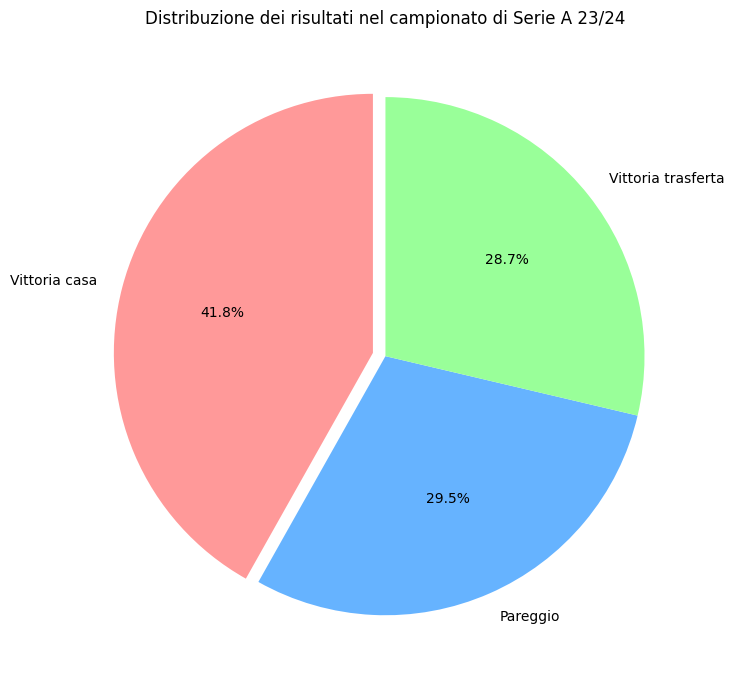

Vittorie in casa: 159 (41.8%)
Pareggi: 112 (29.5%)
Vittorie in trasferta: 109 (28.7%)


In [60]:
# Analizziamo la distribuzione dei risultati (1, X, 2)
risultati_count = matches['Risultato'].value_counts()

# Creiamo un grafico a torta
plt.figure(figsize=(10, 7))
plt.pie(risultati_count, labels=['Vittoria casa', 'Pareggio', 'Vittoria trasferta'] if len(risultati_count) == 3 else risultati_count.index, 
        autopct='%1.1f%%', startangle=90, explode=[0.05, 0, 0] if len(risultati_count) == 3 else None,
        colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribuzione dei risultati nel campionato di Serie A 23/24')
plt.tight_layout()
plt.show()

print(f"Vittorie in casa: {risultati_count.get('1', 0)} ({risultati_count.get('1', 0)/len(matches)*100:.1f}%)")
print(f"Pareggi: {risultati_count.get('X', 0)} ({risultati_count.get('X', 0)/len(matches)*100:.1f}%)")
print(f"Vittorie in trasferta: {risultati_count.get('2', 0)} ({risultati_count.get('2', 0)/len(matches)*100:.1f}%)")

### Analisi statistica del fattore campo

Possiamo formulare un'ipotesi formale sul fattore campo: 

- **H0** (ipotesi nulla): Non c'è differenza significativa tra la probabilità di vittoria in casa e la probabilità di vittoria in trasferta
- **H1** (ipotesi alternativa): La probabilità di vittoria in casa è significativamente maggiore della probabilità di vittoria in trasferta

Verifichiamo questa ipotesi utilizzando un test statistico.

In [61]:
# Estrazione dei dati necessari per il test
home_wins = risultati_count.get('1', 0)
away_wins = risultati_count.get('2', 0)
total_decisive_matches = home_wins + away_wins  # Solo partite con vittoria (senza pareggi)

# Conduzione del test statistico (test chi-quadrato)
observed = [home_wins, away_wins]
expected = [total_decisive_matches/2, total_decisive_matches/2]  # Ipotesi: probabilità uguali

chi2, p_value = stats.chisquare(observed, expected)

alpha = 0.05
print(f"Chi-squared value: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print("\nInterpretazione:")
if p_value < alpha:
    print(f"Il p-value ({p_value:.4f}) è inferiore al livello di significatività ({alpha}), quindi respingiamo l'ipotesi nulla.")
    print("C'è evidenza statistica che le squadre di casa vincono più frequentemente delle squadre in trasferta.")
else:
    print(f"Il p-value ({p_value:.4f}) non è inferiore al livello di significatività ({alpha}), quindi non possiamo respingere l'ipotesi nulla.")
    print("Non c'è sufficiente evidenza statistica per dire che le squadre di casa vincono più frequentemente.")

# Visualizziamo il vantaggio del fattore campo
home_advantage = (home_wins / total_decisive_matches) - (away_wins / total_decisive_matches)
print(f"\nVantaggio del fattore campo: {home_advantage:.2%} in più di probabilità di vincere giocando in casa")

Chi-squared value: 9.3284
P-value: 0.0023

Interpretazione:
Il p-value (0.0023) è inferiore al livello di significatività (0.05), quindi respingiamo l'ipotesi nulla.
C'è evidenza statistica che le squadre di casa vincono più frequentemente delle squadre in trasferta.

Vantaggio del fattore campo: 18.66% in più di probabilità di vincere giocando in casa


## 5. Modello di Predizione basato su Media Gol

Svilupperemo un modello che predice i risultati delle ultime 5 giornate basandosi sulla media dei gol segnati e subiti dalle squadre, considerando separatamente le performance in casa e in trasferta.

Il modello utilizzerà questi dati per stimare il probabile scarto di gol tra le due squadre e determinare il risultato più probabile (vittoria casa, pareggio, vittoria trasferta).

In [62]:
def predict_match_results(matches, threshold_home,threshold_away):
    """
    Predice i risultati delle partite dalla giornata 33 in poi utilizzando
    le medie dei gol fatti e subiti da ciascuna squadra.
    
    Args:
        matches: DataFrame con tutti i dati delle partite
        threshold_home: Differenza di gol necessaria per predire una vittoria in casa
        threshold_away: Differenza di gol necessaria per predire una vittoria in trasferta
    
    Returns:
        DataFrame con le predizioni e i risultati reali
    """
    # Divisione dei dati in training (giornate 1-32) e test (giornate 33-38)
    train_df = matches[matches["Round"] < 33].copy()
    test_df = matches[matches["Round"] >= 33].copy()
    
    # Calcolo delle statistiche per ogni squadra
    teams = pd.unique(matches[['Home Team', 'Away Team']].values.ravel())
    team_stats = {}
    
    for team in teams:
        # Filtra le partite in casa e in trasferta per questa squadra
        home_matches = train_df[train_df['Home Team'] == team]
        away_matches = train_df[train_df['Away Team'] == team]
        
        # Calcola le medie dei gol (evita divisione per zero)
        avg_home_scored = home_matches['Score_casa'].mean() if len(home_matches) > 0 else 0
        avg_home_conceded = home_matches['Score_trasferta'].mean() if len(home_matches) > 0 else 0
        avg_away_scored = away_matches['Score_trasferta'].mean() if len(away_matches) > 0 else 0
        avg_away_conceded = away_matches['Score_casa'].mean() if len(away_matches) > 0 else 0
        
        team_stats[team] = {
            'avg_home_scored': avg_home_scored,
            'avg_home_conceded': avg_home_conceded,
            'avg_away_scored': avg_away_scored,
            'avg_away_conceded': avg_away_conceded
        }
    
    # Effettua le predizioni
    predictions = []
    
    for _, match in test_df.iterrows():
        home_team = match['Home Team']
        away_team = match['Away Team']
        
        # Calcolo dei gol attesi
        home_exp_goals = (team_stats[home_team]['avg_home_scored'] + 
                          team_stats[away_team]['avg_away_conceded']) / 2
        away_exp_goals = (team_stats[away_team]['avg_away_scored'] + 
                          team_stats[home_team]['avg_home_conceded']) / 2
        
        # Predici il risultato basandosi sulla differenza di gol e sul threshold
        goal_diff = home_exp_goals - away_exp_goals
        
        if goal_diff >  threshold_home:
            prediction = '1'  # Vittoria casa
        elif goal_diff < -threshold_away:
            prediction = '2'  # Vittoria trasferta
        else:
            prediction = 'X'  # Pareggio
        
        predictions.append(prediction)
    
    # Aggiungi le predizioni al DataFrame dei risultati
    test_df['Prediction'] = predictions
    
    # Calcola l'accuratezza
    accuracy = (test_df['Risultato'] == test_df['Prediction']).mean()
    print(f"Accuratezza della predizione: {accuracy:.2f}")
    
    return test_df, team_stats, accuracy

In [63]:
# Ottimizzazione della ricerca a griglia con approccio in due fasi
best_acc = 0
best_threshold_home = 0.1
best_threshold_away = 0.0

# FASE 1: Ricerca grossolana con incrementi di 0.1
print("FASE 1: Ricerca grossolana con passo 0.1")
coarse_threshold_range = np.arange(0.1, 1.0, 0.1)
for th_home in coarse_threshold_range:
    for th_away in coarse_threshold_range:
        _, _, acc = predict_match_results(matches, threshold_home=th_home, threshold_away=th_away)
        print(f"Threshold casa: {th_home:.1f}, Threshold trasferta: {th_away:.1f}, Accuratezza: {acc:.2f}")
        
        if acc > best_acc:
            best_acc = acc
            best_threshold_home = th_home
            best_threshold_away = th_away

print(f"\nMiglior risultato grossolano: Threshold casa = {best_threshold_home:.1f}, "
      f"Threshold trasferta = {best_threshold_away:.1f}, Accuratezza: {best_acc:.2f}")

# FASE 2: Ricerca fine intorno ai migliori valori trovati
print("\nFASE 2: Ricerca fine con passo 0.01 intorno ai valori migliori")
fine_home_range = np.arange(max(0.1, best_threshold_home - 0.1), 
                          min(0.9, best_threshold_home + 0.1) + 0.01, 0.01)
fine_away_range = np.arange(max(0.1, best_threshold_away - 0.1), 
                          min(0.9, best_threshold_away + 0.1) + 0.01, 0.01)

for th_home in fine_home_range:
    for th_away in fine_away_range:
        _, _, acc = predict_match_results(matches, threshold_home=th_home, threshold_away=th_away)
        print(f"Threshold casa: {th_home:.2f}, Threshold trasferta: {th_away:.2f}, Accuratezza: {acc:.2f}")
        
        if acc > best_acc:
            best_acc = acc
            best_threshold_home = th_home
            best_threshold_away = th_away

print(f"\nMiglior combinazione finale: Threshold casa = {best_threshold_home:.2f}, "
      f"Threshold trasferta = {best_threshold_away:.2f}, Accuratezza: {best_acc:.2f}")

# Visualizziamo i risultati finali con i threshold ottimali
final_predictions, _, _ = predict_match_results(matches, threshold_home=best_threshold_home, 
                                               threshold_away=best_threshold_away)

FASE 1: Ricerca grossolana con passo 0.1
Accuratezza della predizione: 0.42
Threshold casa: 0.1, Threshold trasferta: 0.1, Accuratezza: 0.42
Accuratezza della predizione: 0.40
Threshold casa: 0.1, Threshold trasferta: 0.2, Accuratezza: 0.40
Accuratezza della predizione: 0.38
Threshold casa: 0.1, Threshold trasferta: 0.3, Accuratezza: 0.38
Accuratezza della predizione: 0.38
Threshold casa: 0.1, Threshold trasferta: 0.4, Accuratezza: 0.38
Accuratezza della predizione: 0.37
Threshold casa: 0.1, Threshold trasferta: 0.5, Accuratezza: 0.37
Accuratezza della predizione: 0.37
Threshold casa: 0.1, Threshold trasferta: 0.6, Accuratezza: 0.37
Accuratezza della predizione: 0.37
Threshold casa: 0.1, Threshold trasferta: 0.7, Accuratezza: 0.37
Accuratezza della predizione: 0.37
Threshold casa: 0.1, Threshold trasferta: 0.8, Accuratezza: 0.37
Accuratezza della predizione: 0.37
Threshold casa: 0.1, Threshold trasferta: 0.9, Accuratezza: 0.37
Accuratezza della predizione: 0.43
Threshold casa: 0.2, Thr

In [64]:
# Eseguire la predizione con il threshold ottimale
predictions_df, team_stats, _ = predict_match_results(matches, threshold_home=best_threshold_home, 
                                               threshold_away=best_threshold_away)

# Visualizziamo il riassunto dei risultati per giornata
results_by_round = predictions_df.groupby('Round').apply(lambda x: (x['Risultato'] == x['Prediction']).mean())
print("Accuratezza per giornata:")
print(results_by_round)

# Visualizziamo i risultati per l'ultima giornata
round_num = 38
round_df = predictions_df[predictions_df['Round'] == round_num]
print(f"\n=== Giornata {round_num} ===")
print(round_df[['Home Team', 'Away Team', 'Score_casa', 'Score_trasferta', 'Risultato', 'Prediction']])

Accuratezza della predizione: 0.53
Accuratezza per giornata:
Round
33    0.2
34    0.9
35    0.6
36    0.6
37    0.6
38    0.3
dtype: float64

=== Giornata 38 ===
         Home Team    Away Team  Score_casa  Score_trasferta Risultato  \
369       Cagliari   Fiorentina           2                3         2   
370          Genoa      Bologna           2                0         1   
371       Juventus        Monza           2                0         1   
372          Milan  Salernitana           3                3         X   
373       Atalanta       Torino           3                0         1   
374         Napoli        Lecce           0                0         X   
375         Empoli         Roma           2                1         1   
376      Frosinone      Udinese           0                1         2   
377  Hellas Verona        Inter           2                2         X   
378          Lazio     Sassuolo           1                1         X   

    Prediction  
369  

C:\Users\Mario\AppData\Local\Temp\ipykernel_15504\2259107417.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_by_round = predictions_df.groupby('Round').apply(lambda x: (x['Risultato'] == x['Prediction']).mean())


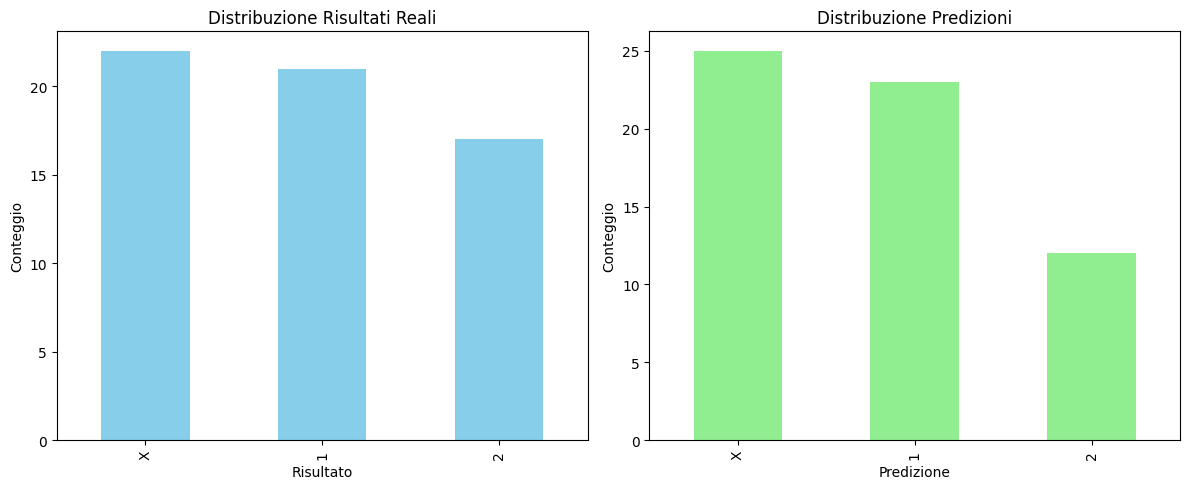

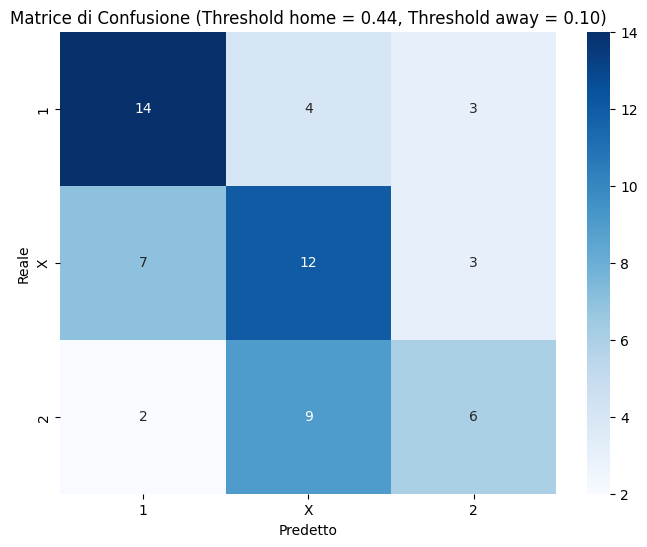

In [65]:
# Confrontiamo la distribuzione delle predizioni con i risultati reali
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
predictions_df['Risultato'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribuzione Risultati Reali')
plt.xlabel('Risultato')
plt.ylabel('Conteggio')

plt.subplot(1, 2, 2)
predictions_df['Prediction'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribuzione Predizioni')
plt.xlabel('Predizione')
plt.ylabel('Conteggio')

plt.tight_layout()
plt.show()

# Matrice di confusione
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predictions_df['Risultato'], predictions_df['Prediction'], labels=['1', 'X', '2'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title(f'Matrice di Confusione (Threshold home = {best_threshold_home:.2f}, Threshold away = {best_threshold_away:.2f})')
plt.show()